In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Load the dataset
data = pd.read_csv(r'e:\desktop files\Internship Projects\Customer Segmentation\Customers.csv')
df=pd.DataFrame(data)
data.info()
df = df.drop(columns=['CustomerID'], axis=1)
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB


,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,Male,19,15000,39,Healthcare,1,4
1,Male,21,35000,81,Engineer,3,3
2,Female,20,86000,6,Engineer,1,1
3,Female,23,59000,77,Lawyer,0,2
4,Female,31,38000,40,Entertainment,2,6


In [24]:
# Check for missing values
print("Missing values in the dataset:")
print(df.isnull().sum())

Missing values in the dataset:
Gender                     0
Age                        0
Annual Income ($)          0
Spending Score (1-100)     0
Profession                35
Work Experience            0
Family Size                0
dtype: int64


In [25]:
# Handle missing values in 'Profession' column
imputer = SimpleImputer(strategy='most_frequent')
data['Profession'] = imputer.fit_transform(data[['Profession']]).ravel()
print(data.isnull().sum())

CustomerID                0
Gender                    0
Age                       0
Annual Income ($)         0
Spending Score (1-100)    0
Profession                0
Work Experience           0
Family Size               0
dtype: int64


In [26]:
# Check for duplicates
print("\nDuplicates in the dataset:")
print(data.duplicated().sum())

# Remove duplicates if any
data = data.drop_duplicates()


Duplicates in the dataset:
0


In [27]:
# Separate into categorical and numerical data
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_data = df[categorical_cols]
numerical_data = df[numerical_cols]
numerical_data.head()


,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
0,19,15000,39,1,4
1,21,35000,81,3,3
2,20,86000,6,1,1
3,23,59000,77,0,2
4,31,38000,40,2,6


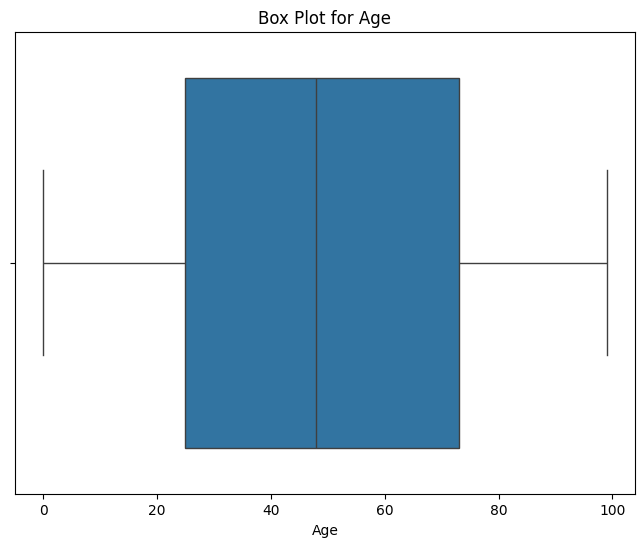

In [28]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Age'])
plt.title('Box Plot for Age')
plt.show()

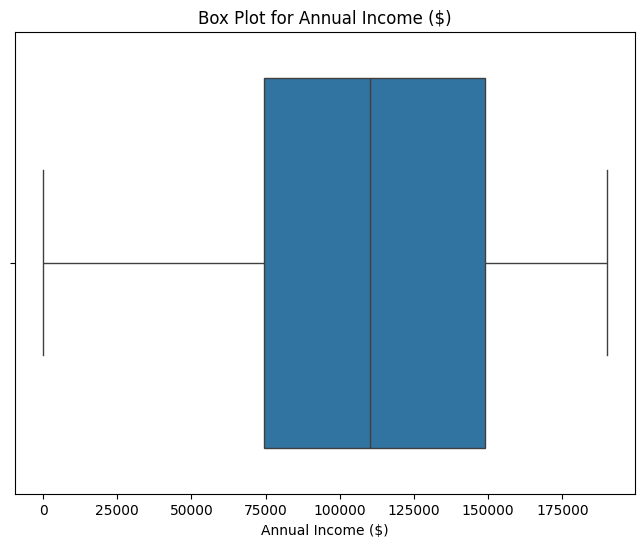

In [29]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Annual Income ($)'])
plt.title('Box Plot for Annual Income ($)')
plt.show()

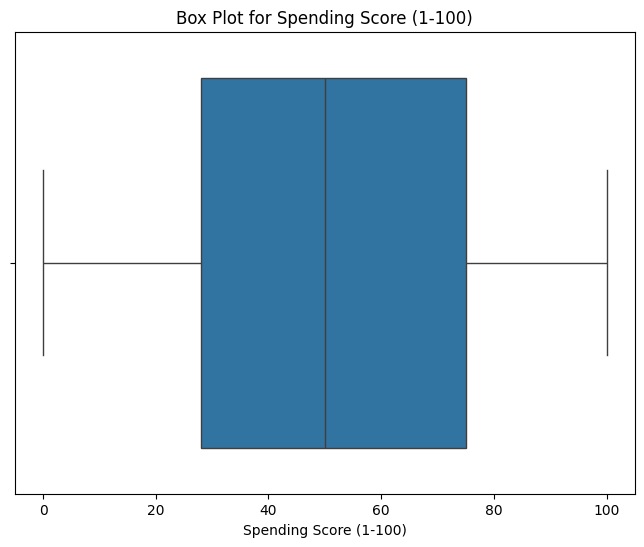

In [30]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Spending Score (1-100)'])
plt.title('Box Plot for Spending Score (1-100)')
plt.show()

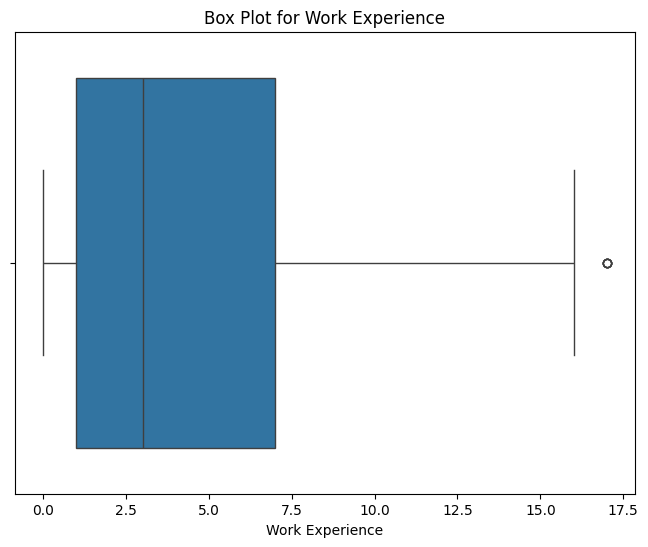

In [31]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Work Experience'])
plt.title('Box Plot for Work Experience')
plt.show()

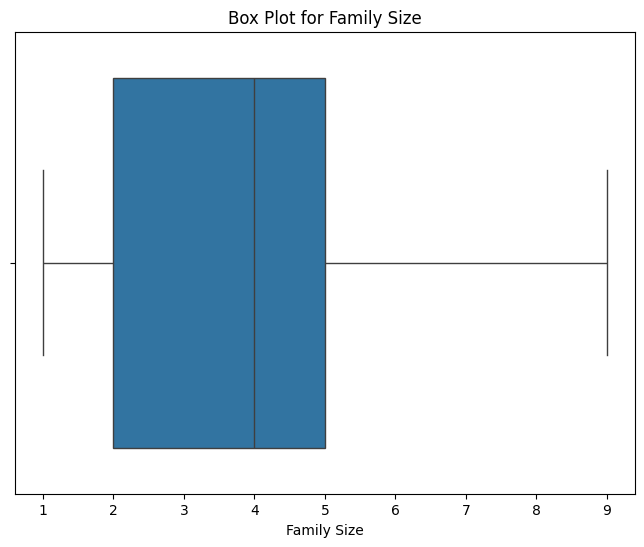

In [32]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Family Size'])
plt.title('Box Plot for Family Size')
plt.show()

In [33]:
def treat_outliers_iqr(df, Work_Experience):
    df_treated = df.copy()  # Create a copy to avoid modifying the original data
    col_data = df_treated[Work_Experience].dropna()  # Drop missing values
    
    Q1 = col_data.quantile(0.25)  # 1st quartile
    Q3 = col_data.quantile(0.75)  # 3rd quartile
    IQR = Q3 - Q1  # Interquartile Range
    
    lower_bound = Q1 - 1.5 * IQR  # Lower bound for outliers
    upper_bound = Q3 + 1.5 * IQR  # Upper bound for outliers

    # Replace outliers with the median of the column
    median = col_data.median()
    df_treated[Work_Experience] = df_treated[Work_Experience].apply(
        lambda x: median if x < lower_bound or x > upper_bound else x
    )
    
    return df_treated


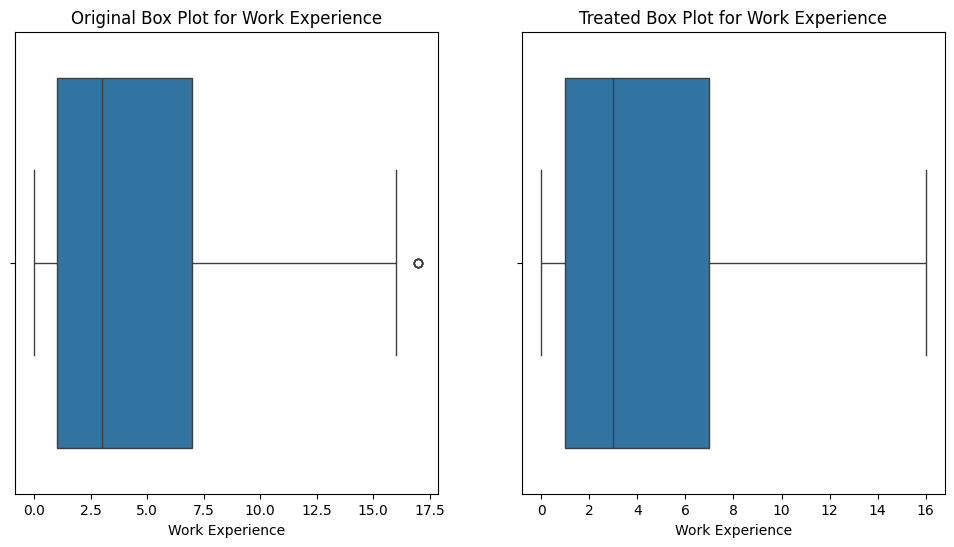

In [34]:
def plot_box_plots(df,df_treated, Work_Experience):
    plt.figure(figsize=(12, 6))
    
    # Original Data
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[Work_Experience])
    plt.title(f'Original Box Plot for {Work_Experience}')
    
    # Treated Data
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_treated[Work_Experience])
    plt.title(f'Treated Box Plot for {Work_Experience}')
    
    plt.show()

# Apply the function to treat outliers in the 'Work Experience' column
treated_df = treat_outliers_iqr(df, 'Work Experience')

# Plot the box plots for original and treated data
plot_box_plots(df, treated_df, 'Work Experience')

In [35]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to 'Color'
df['gender_LabelEncoded'] = label_encoder.fit_transform(df['Gender'])

# Apply Label Encoding to 'Size'
df['profession_LabelEncoded'] = label_encoder.fit_transform(df['Profession'])
encoded_df = df[['gender_LabelEncoded', 'profession_LabelEncoded']]

print(encoded_df)

      gender_LabelEncoded  profession_LabelEncoded
0                       1                        5
1                       1                        2
2                       0                        2
3                       0                        7
4                       0                        3
...                   ...                      ...
1995                    0                        0
1996                    0                        1
1997                    1                        5
1998                    1                        4
1999                    1                        3

[2000 rows x 2 columns]


In [36]:
columns_to_drop = ['Gender', 'Profession', 'Age', 'gender_LabelEncoded']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)
print("Remaining columns in DataFrame:")
print(df.columns)


Remaining columns in DataFrame:
Index(['Annual Income ($)', 'Spending Score (1-100)', 'Work Experience',
       'Family Size', 'profession_LabelEncoded'],
      dtype='object')


In [37]:
# Select columns for correlation matrix
df_numeric = df[['profession_LabelEncoded', 'Annual Income ($)', 'Spending Score (1-100)', 'Work Experience', 'Family Size']]

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Print the correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                         profession_LabelEncoded  Annual Income ($)  \
profession_LabelEncoded                 1.000000           0.020446   
Annual Income ($)                       0.020446           1.000000   
Spending Score (1-100)                 -0.053433           0.023299   
Work Experience                        -0.002378           0.089136   
Family Size                             0.046138           0.093005   

                         Spending Score (1-100)  Work Experience  Family Size  
profession_LabelEncoded               -0.053433        -0.002378     0.046138  
Annual Income ($)                      0.023299         0.089136     0.093005  
Spending Score (1-100)                 1.000000        -0.028948     0.002232  
Work Experience                       -0.028948         1.000000     0.011873  
Family Size                            0.002232         0.011873     1.000000  


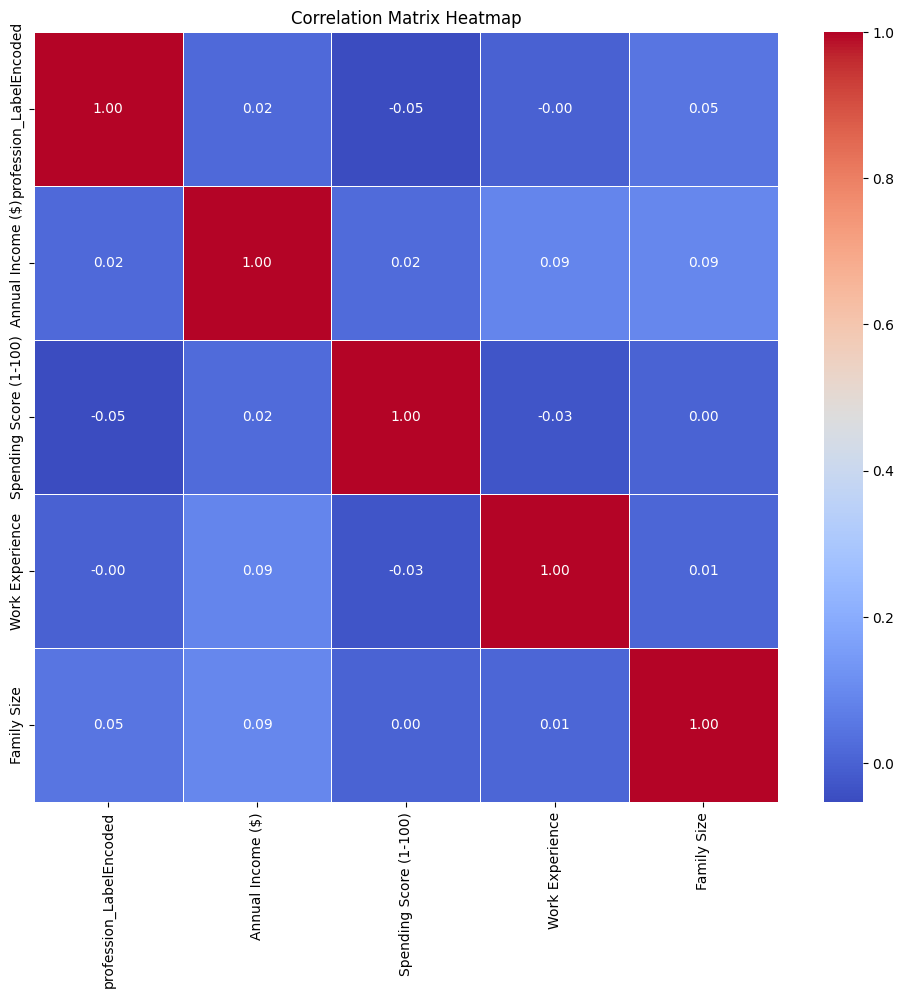

In [38]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [39]:
print(df.columns)

Index(['Annual Income ($)', 'Spending Score (1-100)', 'Work Experience',
       'Family Size', 'profession_LabelEncoded'],
      dtype='object')


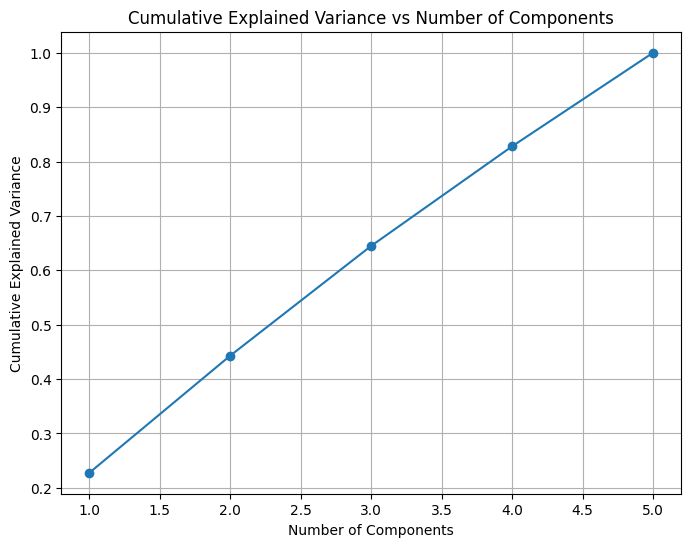

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# Assuming df is your DataFrame
# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
train_data_scaled= scaler.fit_transform(train_data)

# Transform the testing data using the same scaler
test_data_scaled= scaler.transform(test_data)



from sklearn.decomposition import PCA

# Assuming you have scaled your data
pca = PCA()
pca.fit(train_data_scaled)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()



In [41]:
# Initialize PCA (e.g., reduce to 2 components for visualization)
pca = PCA(n_components=4)

# Fit PCA on the scaled training data and transform it
train_data_pca = pca.fit_transform(train_data_scaled)

# Transform the scaled testing data using the same PCA
test_data_pca = pca.transform(test_data_scaled)

# Print the shape of the resulting datasets to verify the split and PCA transformation
print(f"Training data shape after scaling: {train_data_scaled.shape}")
print(f"Testing data shape after scaling: {test_data_scaled.shape}")
print(f"Training data shape after PCA: {train_data_pca.shape}")
print(f"Testing data shape after PCA: {test_data_pca.shape}")


Training data shape after scaling: (1600, 5)
Testing data shape after scaling: (400, 5)
Training data shape after PCA: (1600, 4)
Testing data shape after PCA: (400, 4)


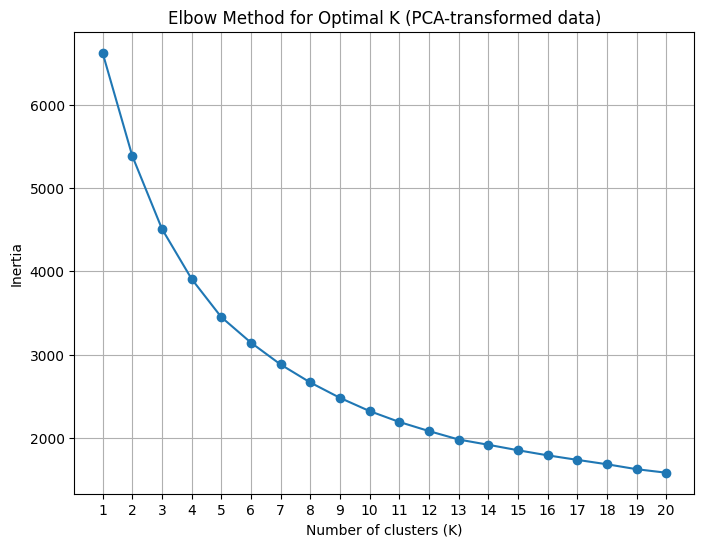

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


# Compute the Elbow diagram using KMeans on PCA-transformed training data
inertia_values = []
k_range = range(1, 21)  # Increase K values from 1 to 20

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(train_data_pca)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow diagram
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal K (PCA-transformed data)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)  # Add ticks for clarity
plt.grid(True)
plt.show()


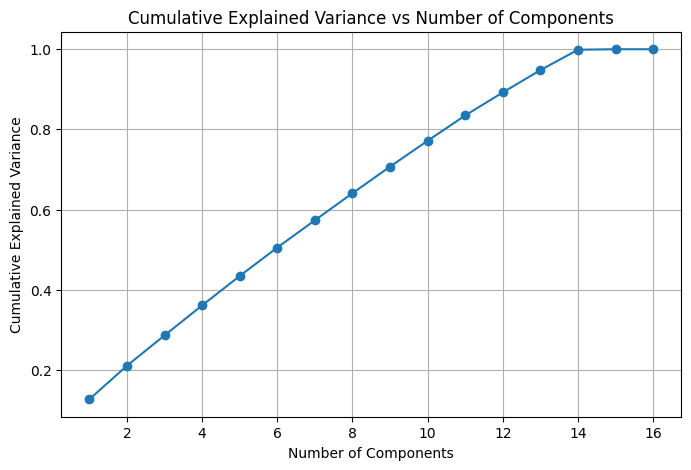

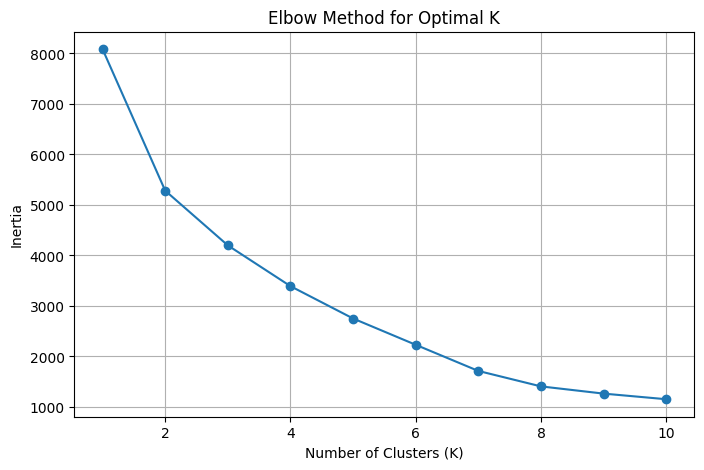

K = 2 → Silhouette Score = 0.36
K = 3 → Silhouette Score = 0.35
K = 4 → Silhouette Score = 0.38
K = 5 → Silhouette Score = 0.43

✅ Optimal K = 3 with Silhouette Score = 0.35


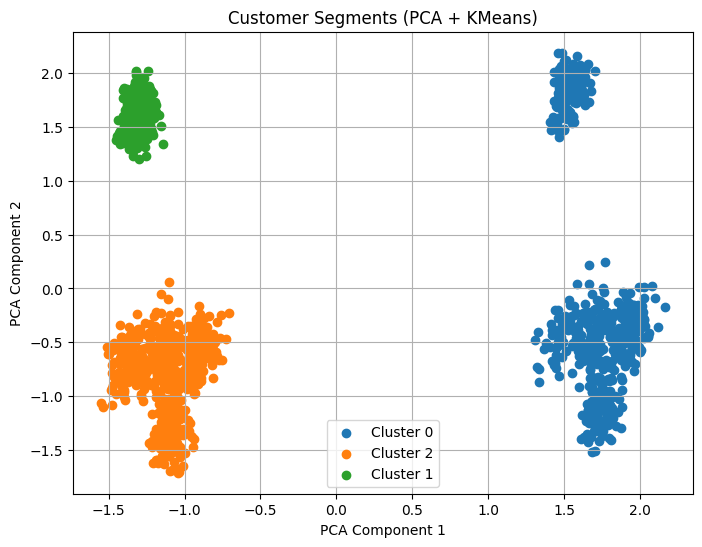

In [43]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# Step 1: Load dataset
df = pd.read_csv(r'e:\desktop files\Internship Projects\Customer Segmentation\Customers.csv')
df = df.drop(columns=['CustomerID'], axis=1)

# Step 2: One-hot encode categorical columns
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols)

# Step 3: Train/test split
X = df.copy()
train, test = train_test_split(X, test_size=0.3, random_state=42)

# Step 4: Standardize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Step 5: PCA – Explained Variance Plot
pca = PCA()
pca.fit(train_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Step 6: Apply PCA with 4 components
pca = PCA(n_components=4)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)

# Step 7: Elbow Method to choose K
inertias = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(train_pca)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Step 8: Silhouette Score Evaluation
silhouette_scores = {}
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(train_pca)
    score = silhouette_score(train_pca, labels)
    silhouette_scores[k] = score
    print(f"K = {k} → Silhouette Score = {score:.2f}")

# Step 9: Choose best K (closest to 0.50 silhouette score)
best_k = max(silhouette_scores, key=lambda k: abs(silhouette_scores[k] - 0.50))
print(f"\n✅ Optimal K = {best_k} with Silhouette Score = {silhouette_scores[best_k]:.2f}")

# Step 10: Final Clustering with best K
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
final_labels = kmeans_final.fit_predict(train_pca)

# Step 11: Add cluster labels for visualization
train_pca_df = pd.DataFrame(train_pca, columns=[f'PC{i+1}' for i in range(4)])
train_pca_df['Cluster'] = final_labels

# Step 12: Visualize clusters using first 2 PCA components
plt.figure(figsize=(8, 6))
for cluster in train_pca_df['Cluster'].unique():
    cluster_data = train_pca_df[train_pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Customer Segments (PCA + KMeans)")
plt.legend()
plt.grid(True)
plt.show()


In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Inspect df.columns before this line and drop ID column if present
df_features = df.copy()  # Or drop your ID column if needed

# Split into train/test
X_train, X_test = train_test_split(df_features, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


✅ Best Training Silhouette Score: 0.22
Optimal eps: 1.8999999999999997
Optimal min_samples: 7


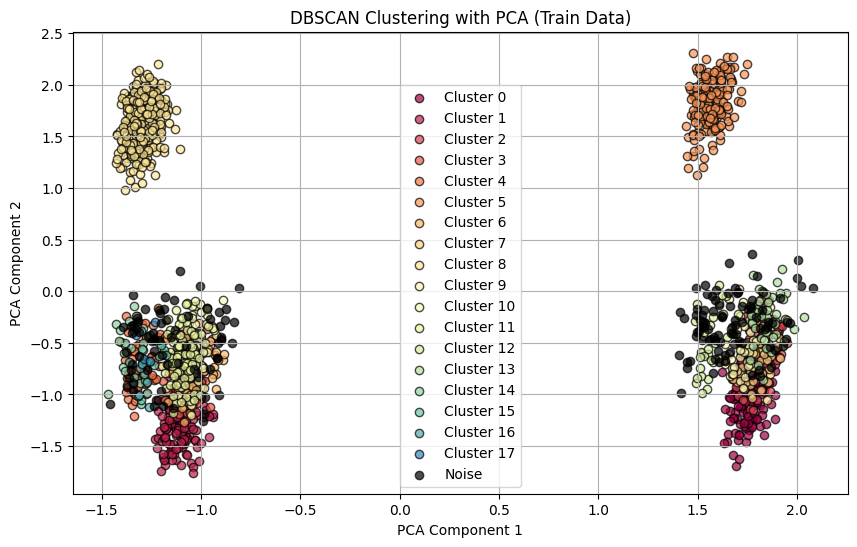

In [45]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Define parameter ranges
eps_values = np.arange(0.5, 2.0, 0.1)
min_samples_values = range(3, 10)

# Variables to track the best configuration
best_silhouette_train = -1
best_dbscan_model = None
best_train_labels = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
        train_labels = dbscan_model.fit_predict(X_train_scaled)

        # Filter out if fewer than 2 clusters found
        n_clusters = len(set(train_labels)) - (1 if -1 in train_labels else 0)
        if n_clusters >= 2:
            silhouette_train = silhouette_score(X_train_scaled, train_labels)

            if silhouette_train > best_silhouette_train:
                best_silhouette_train = silhouette_train
                best_dbscan_model = dbscan_model
                best_train_labels = train_labels

# Display best results
if best_dbscan_model is not None:
    print(f"✅ Best Training Silhouette Score: {best_silhouette_train:.2f}")
    print(f"Optimal eps: {best_dbscan_model.eps}")
    print(f"Optimal min_samples: {best_dbscan_model.min_samples}")

    # PCA for 2D visualization
    pca = PCA(n_components=2)
    train_pca = pca.fit_transform(X_train_scaled)

    # Plot
    plt.figure(figsize=(10, 6))
    unique_labels = set(best_train_labels)
    for label in unique_labels:
        color = 'k' if label == -1 else plt.cm.Spectral(float(label) / len(unique_labels))
        mask = (best_train_labels == label)
        label_name = 'Noise' if label == -1 else f'Cluster {label}'
        plt.scatter(train_pca[mask, 0], train_pca[mask, 1], c=[color], label=label_name, edgecolors='k', alpha=0.7)

    plt.title("DBSCAN Clustering with PCA (Train Data)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("❌ No valid DBSCAN clustering found.")


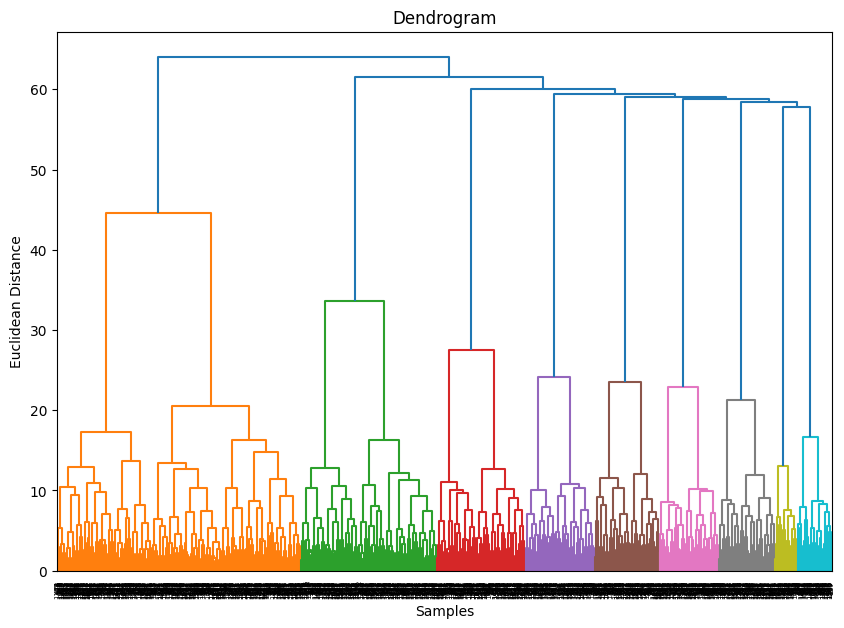

✅ Train Silhouette Score: 0.14
✅ Train Davies-Bouldin Index: 2.41


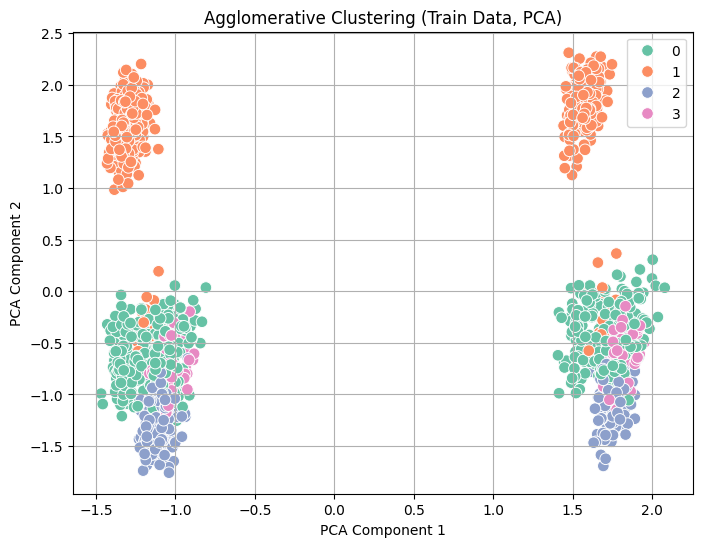

✅ Test Silhouette Score: 0.15
✅ Test Davies-Bouldin Index: 2.03


In [46]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import scipy.cluster.hierarchy as sch
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Dendrogram
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(X_train_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean Distance')
plt.show()

# Step 2: Agglomerative Clustering
n_clusters = 4  # Adjust based on dendrogram
agg_model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

# Train
train_clusters = agg_model.fit_predict(X_train_scaled)

# Evaluate
silhouette_train = silhouette_score(X_train_scaled, train_clusters)
db_index_train = davies_bouldin_score(X_train_scaled, train_clusters)

print(f"✅ Train Silhouette Score: {silhouette_train:.2f}")
print(f"✅ Train Davies-Bouldin Index: {db_index_train:.2f}")

# Visualization
pca = PCA(n_components=2)
train_pca = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train_pca[:, 0], y=train_pca[:, 1], hue=train_clusters, palette='Set2', s=70)
plt.title('Agglomerative Clustering (Train Data, PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

# Step 3: Evaluate on Test Data
test_clusters = agg_model.fit_predict(X_test_scaled)
silhouette_test = silhouette_score(X_test_scaled, test_clusters)
db_index_test = davies_bouldin_score(X_test_scaled, test_clusters)

print(f"✅ Test Silhouette Score: {silhouette_test:.2f}")
print(f"✅ Test Davies-Bouldin Index: {db_index_test:.2f}")


In [47]:
# Assign labels to full training set
df_with_clusters = pd.DataFrame(X_train_scaled, columns=[f'Feature_{i+1}' for i in range(X_train_scaled.shape[1])])
df_with_clusters['Cluster'] = best_train_labels

# Optional: Map clusters to segment names
df_with_clusters['Segment'] = df_with_clusters['Cluster'].map({
    0: 'Group A',
    1: 'Group B',
    2: 'Group C',
    -1: 'Noise'
})

# Save to CSV
df_with_clusters.to_csv("DBSCAN_Customer_Clusters.csv", index=False)
print("✅ Clustered data saved as 'DBSCAN_Customer_Clusters.csv'")


✅ Clustered data saved as 'DBSCAN_Customer_Clusters.csv'
